In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import os
import tifffile as tf
from scipy import ndimage, stats
import utils
import math
import matplotlib as mpl
from importlib import reload
from sklearn import cluster

In [2]:
fsrc = '../Bacteria Info for Erik/'
csrc = '../data/'
wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
sample = 'D2'
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#c44601', '#054fb9', '#5ba300', '#8babf1', '#e6308a', '#5928ed']
cmap = ['Blues_r', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r', 'YlOrBr_r', 'gray', 'gist_gray', 'Wistia']
fs = 15
rng = np.random.default_rng(42)
pxs = 75
pxbar = np.s_[-15:-5, 5:5 + pxs]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))

ksrc += sample + os.sep

dst = fsrc

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col = 0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))
transcriptomes = np.asarray(metatrans['gene'])

Cells = pd.read_excel(fsrc + 'Infected Cells w. Nuc.xlsx').values.squeeze()
cells = np.zeros_like(Cells)
for i in range(len(Cells)):
    cells[i] = metacell[metacell['orig_cellID'] == Cells[i]].index[0]

nuccutoff = 1
voronoi = tf.imread(nsrc + sample + '_EDT.tif')
nuclei = voronoi < nuccutoff

lnuc, nnuc = ndimage.label(nuclei, ndimage.generate_binary_structure(2,1))
nuc_area, _ = np.histogram(lnuc, bins=np.arange(nnuc + 2))
nuc_area[0] = 0 #ignore the non-nuclear area
print('Detected',nnuc,'nuclei')

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = mpl.colors.ListedColormap(foo)


wall[nuclei] = False
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

filename = csrc + sample + '_data/32771-slide1_' + sample + '_results.txt'
tlocs = pd.read_csv(filename, header=None, sep='\t').drop(columns=[4])
tlocs.columns = ['X', 'Y', 'Z', 'T']

transcriptomes, invidx, tsize = np.unique(tlocs.loc[:,'T'], return_index = False, return_inverse=True, return_counts=True) 
tlocs = tlocs.loc[:, ['X','Y','Z']]
tlocs['L'] = 'c'
print('\nFound data for', len(transcriptomes), 'transcriptomes')
zmax = tlocs['Z'].max()
zmin = tlocs['Z'].min()
bins = np.arange(zmin, zmax+1, 1)
hparams = {'bins':bins, 'alpha':0.5, 'density':True, 'orientation':'horizontal', 'zorder':2}
fs = 15

translocs = [None for i in range(len(transcriptomes))]
for tidx in range(len(transcriptomes)):
    translocs[tidx] = tlocs.loc[invidx == tidx].copy()
    translocs[tidx]['tidx'] = tidx

tbac = pd.concat(translocs[:10], ignore_index=True)
tbac['cidx'] = label[ tbac['Y'], tbac['X'] ]
tbac['nidx'] =  lnuc[ tbac['Y'], tbac['X'] ]

nuct = tbac.loc[ nuclei[ tbac['Y'], tbac['X'] ] ]
cytt = tbac.loc[~nuclei[ tbac['Y'], tbac['X'] ] ]
print(nuct.shape, cytt.shape)

tgen = pd.concat(translocs[10:], ignore_index=True)
tgen['cidx'] = label[ tgen['Y'], tgen['X'] ]
tgen['nidx'] =  lnuc[ tgen['Y'], tgen['X'] ]

nucg = tgen.loc[ nuclei[ tgen['Y'] , tgen['X'] ] ]
print(tgen.shape, nucg.shape)

Detected 1365 nuclei

Found data for 97 transcriptomes
(24596, 7) (1963314, 7)
(1842474, 7) (102868, 7)


In [6]:
i = 1647
#i = 1267
#i = 168
#i = 235
#i = 305
#i = 235
#i = 994
#i = 325
#i = 330
#i = 372

cidx = 150
cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc)
s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]

nidxs, ncts = np.unique(lnuc[s_][ (lnuc[s_] > 0) & (label[s_] == cidx) ], return_counts=True)

cx,cy,cz = cytt.loc[ cytt['cidx'] == cidx , ['X', 'Y', 'Z'] ].values.T
nbac = [ nuct.loc[ (nuct['cidx'] == cidx) & (nuct['nidx'] == nidx) , ['X', 'Y', 'Z'] ].values.T for nidx in nidxs ]
ngen = [ nucg.loc[ (nucg['cidx'] == cidx) & (nucg['nidx'] == nidx) , ['X', 'Y', 'Z'] ].values.T for nidx in nidxs ]

print(nidxs, ncts)
print(list( map(np.shape, nbac) ))
print(list( map(np.shape, ngen) ))

[57 83 89] [ 883 4179  162]
[(3, 0), (3, 80), (3, 0)]
[(3, 20), (3, 245), (3, 6)]


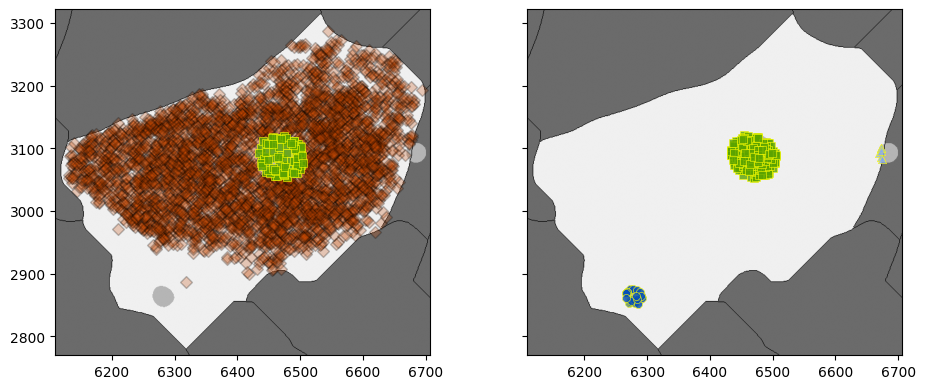

In [7]:
fig, ax = plt.subplots( 1, 2 , figsize=(10, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

for j in range(len(ax)):
    ax[j].imshow(cell+1, cmap=cellular_cmap, origin='lower', extent=cextent, vmin=0, vmax=nnuc+2, zorder=1);
    ax[j].set_facecolor('#808080')
    #ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

j = 0
ax[j].scatter(cx,cy, c=color[0], marker=marker[0], edgecolor='k', alpha=0.25, zorder=2)
for k in range(len(nbac)):
    ax[0].scatter(nbac[k][0],nbac[k][1], c=color[k+1], marker=marker[k+1], edgecolor='yellow', alpha=0.8, zorder=3, linewidth=0.5)
    ax[1].scatter(ngen[k][0],ngen[k][1], c=color[k+1], marker=marker[k+1], edgecolor='yellow', alpha=0.8, zorder=3, linewidth=0.5)

fig.tight_layout();

80
KstestResult(statistic=0.5436872909698997, pvalue=5.5851283226289145e-21, statistic_location=27, statistic_sign=-1)
--


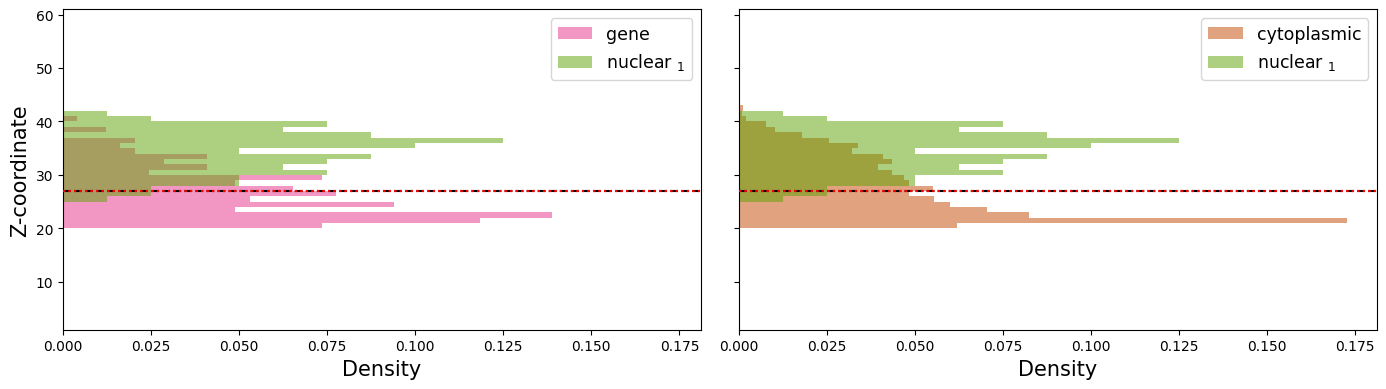

In [371]:
fig, ax = plt.subplots( 1, 2, figsize=(14,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

h = ax[1].hist(cz, color=color[0], label='cytoplasmic', **hparams)

for k in np.nonzero(np.array([ x.shape[1] for x in nbac ]) > 9 )[0]:
    NZ = nbac[k][2]
    h = ax[0].hist(ngen[k][2], color=color[-1-k], label='gene', **hparams)
    h = ax[0].hist(NZ, color=color[k+1], label='nuclear $_{}$'.format(k), **hparams)
    h = ax[1].hist(NZ, color=color[k+1], label='nuclear $_{}$'.format(k), **hparams)
    dbscan = cluster.DBSCAN(eps=3.5, min_samples=9, n_jobs=1).fit_predict(NZ.reshape(-1,1))
    uq = np.unique(dbscan)
    for i in uq[uq > -1]:
        
        nz = NZ[dbscan == i]
        print(len(nz))
        ksless = stats.ks_2samp(nz,cz,'less', method='asymp')
        ksgreater = stats.ks_2samp(nz,cz,'greater', method='asymp')
        for ks in [ksless, ksgreater]:
            if ks.pvalue < 1e-2:
                print(ks, '--', sep='\n')
                ax[0].axhline(ks.statistic_location-0*ks.statistic_sign, c='k', ls='--', zorder=3)
                ax[1].axhline(ks.statistic_location-0*ks.statistic_sign, c='k', ls='--', zorder=3)

ksless = stats.ks_2samp(NZ,cz,'less', method='asymp')
ksgreater = stats.ks_2samp(NZ,cz,'greater', method='asymp')
ax[0].set_ylabel('Z-coordinate', fontsize=fs)
for j in [0,1]:
    for ks in [ksless, ksgreater]:
        if ks.pvalue < 0.01:
            ax[0].axhline(ks.statistic_location-0*ks.statistic_sign, c='r', ls=':', zorder=4)
            ax[1].axhline(ks.statistic_location-0*ks.statistic_sign, c='r', ls=':', zorder=4)
    ax[j].set_xlabel('Density', fontsize=fs)    
    ax[j].set_ylim(zmin,zmax)
    ax[j].legend(fontsize=12.5, loc='upper right');

fig.tight_layout();
#plt.savefig(dst + 'foo.jpg', bbox_inches='tight')

In [344]:
print(ksless)
print(ksgreater)

KstestResult(statistic=0.05302442007651719, pvalue=0.4530211442609242, statistic_location=18, statistic_sign=-1)
KstestResult(statistic=0.22709248908421165, pvalue=8.202740096239198e-07, statistic_location=29, statistic_sign=1)


In [323]:
print( len(NZ) )
print( np.sum(NZ < ksless.statistic_location), np.sum(NZ < ksless.statistic_location)/len(NZ), sep='\t')
print( np.sum(NZ > ksgreater.statistic_location), np.sum(NZ > ksgreater.statistic_location)/len(NZ), sep='\t')

111
84	0.7567567567567568
39	0.35135135135135137


In [29]:
cidx = 150
print(metacell.loc[cidx, 'nuclei_area'] > 100)
cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc)
s_= np.s_[ cextent[2]:cextent[3], cextent[0]:cextent[1] ]
    
nidxs, ncts = np.unique(lnuc[s_][ (lnuc[s_] > 0) & (label[s_] == cidx) ], return_counts=True)
perc_nuc_inside = ncts/nuc_area[nidxs]

True


In [30]:
print( ncts/np.sum(ncts),  ncts/nuc_area[nidxs] )
        

[0.16902757 0.79996172 0.03101072] [1.         1.         0.20795892]


In [21]:
nuc_area[nidxs]

array([ 883, 4179,  779])

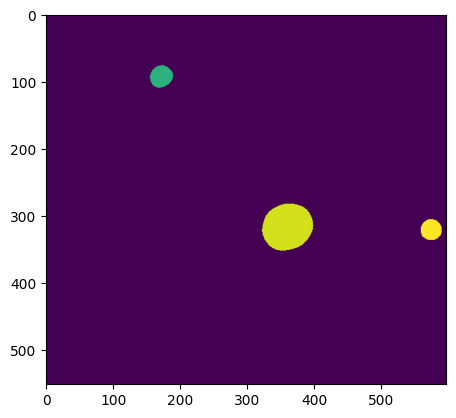

In [16]:
plt.imshow(lnuc[s_])

In [11]:
ncts

array([ 883, 4179,  162])

In [23]:
perc_nuc_inside

array([1.        , 1.        , 0.20795892])

In [24]:
metanuc = dict()
filename = dst + 'BAC_nuclear_localization_estimates_v2.csv'

if os.path.isfile(filename):

    columns = ['ndimage_ID', 'nuc_ID', 'perc_inside', 'N_inside', 
               'pval_up', 'lim_up', 'pval_down', 'lim_down',
               'N_lesser_lim_up', 'N_greater_lim_down', 'r_lesser_lim_up', 'r_greater_lim_down']
    dfastype = {'ndimage_ID':int, 'nuc_ID':int, 'N_inside':int, 'lim_up':int, 'lim_down':int,
                'N_lesser_lim_up':int, 'N_greater_lim_down':int}
    
    nuc_lims = []
    
    for cidx in range(1, len(metacell)+1):
            
        if metacell.loc[cidx, 'nuclei_area'] > 100:
        
            cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc)
            s_= np.s_[ cextent[2]:cextent[3], cextent[0]:cextent[1] ]
                
            nidxs, ncts = np.unique(lnuc[s_][ (lnuc[s_] > 0) & (label[s_] == cidx) ], return_counts=True)
            perc_nuc_inside = ncts/nuc_area[nidxs]
            cx,cy,cz = cytt.loc[ cytt['cidx'] == cidx , ['X', 'Y', 'Z'] ].values.T
            nbac = [ nuct.loc[ (nuct['cidx'] == cidx) & (nuct['nidx'] == nidx) , ['X', 'Y', 'Z'] ].values.T for nidx in nidxs ]
            metanuc[cidx] = [ nidxs, ncts ]
            bar = np.array([ x.shape[1] for x in nbac ])
            
            for k in np.nonzero( bar > 9 )[0]:

                NZ = nbac[k][2]
                ksless = stats.ks_2samp(NZ,cz,'less', method='asymp')
                ksgreater = stats.ks_2samp(NZ,cz,'greater', method='asymp') 
               
                foo = [cidx, nidxs[k], perc_nuc_inside[k], len(nbac[k][2]),
                       ksless.pvalue, ksless.statistic_location, 
                       ksgreater.pvalue, ksgreater.statistic_location, 
                       np.sum(NZ < ksless.statistic_location), np.sum(NZ > ksgreater.statistic_location),
                       np.sum(NZ < ksless.statistic_location)/len(NZ), np.sum(NZ > ksgreater.statistic_location)/len(NZ)
                ]
        
                nuc_lims.append(foo)

            for k in np.nonzero( bar <= 9 )[0]:
                    
                foo = [cidx, nidxs[k], perc_nuc_inside[k], len(nbac[k][2]), 2 , zmax + 1,  2, zmin - 1, 0, 0, 0, 0 ]
                nuc_lims.append(foo)
    
    
    nuc_lims = np.array(nuc_lims)
    df = pd.DataFrame(nuc_lims, columns=columns).astype(dfastype)
    df.to_csv(filename, index=False)
    bar = np.zeros(len(metacell), dtype=int)
    for i in range(len(bar)):
        if i+1 in metanuc:
            bar[i] = len(metanuc[i+1][0])

bacs = pd.read_csv(filename)
print(bacs.shape)
bacs.head()

(1719, 12)


,ndimage_ID,nuc_ID,perc_inside,N_inside,pval_up,lim_up,pval_down,lim_down,N_lesser_lim_up,N_greater_lim_down,r_lesser_lim_up,r_greater_lim_down
0,1,1,0.011579,0,2.0,62,2.0,0,0,0,0.0,0.0
1,1,3,1.000000,0,2.0,62,2.0,0,0,0,0.0,0.0
2,1,4,0.431034,0,2.0,62,2.0,0,0,0,0.0,0.0
3,1,9,1.000000,0,2.0,62,2.0,0,0,0,0.0,0.0
4,1,15,1.000000,0,2.0,62,2.0,0,0,0,0.0,0.0


# Load all data and go thru the rest of genes

In [25]:
bacs.sort_values(by='N_inside', ascending=False).head(10)

,ndimage_ID,nuc_ID,perc_inside,N_inside,pval_up,lim_up,pval_down,lim_down,N_lesser_lim_up,N_greater_lim_down,r_lesser_lim_up,r_greater_lim_down
509,662,386,1.0,217,0.991464,23,4.274566e-17,30,0,46,0.000000,0.211982
396,482,299,1.0,201,0.064063,39,6.079615e-08,25,183,55,0.910448,0.273632
1323,2110,1056,1.0,190,0.999021,17,7.933696e-13,27,0,22,0.000000,0.115789
423,516,319,1.0,170,0.982109,38,1.491578e-08,24,168,42,0.988235,0.247059
490,629,385,1.0,169,0.970079,40,1.682842e-08,29,167,17,0.988166,0.100592
1074,1624,855,1.0,168,0.919143,17,2.969270e-07,25,0,32,0.000000,0.190476
1125,1722,941,1.0,167,0.827570,39,9.436621e-22,23,163,16,0.976048,0.095808
964,1431,765,1.0,166,0.999120,14,3.043060e-08,23,0,28,0.000000,0.168675
627,845,483,1.0,163,0.985465,37,5.287079e-11,23,162,15,0.993865,0.092025
855,1246,682,1.0,161,0.075000,43,5.085489e-10,30,143,42,0.888199,0.260870


In [26]:
pvaltol = 0.025
pvaldirs = ['pval_up', 'pval_down']
filename = ksrc + sample + '_nuclei_limits_v2.csv'

if not os.path.isfile(filename):
    
    cell_nuc = bacs.loc[:, ['ndimage_ID','nuc_ID', 'perc_inside']].drop_duplicates()
    
    N_bot = np.zeros(len(cell_nuc), dtype = int); 
    N_top = N_bot.copy()
    N_inside = N_bot.copy()
    
    P_top = np.zeros(len(cell_nuc)); 
    P_bot = P_top.copy()
    
    for i in range(len(cell_nuc)):
        n_bot, n_top = zmin-1, zmax+1
        p_bot, p_top = 0,0
        cidx, nidx = cell_nuc.iloc[i, :2].values
        
        nuc_lims = bacs.iloc[i]
        N_inside[i] = nuc_lims['N_inside']
        
        if nuc_lims['pval_up'] < pvaltol:
            n_top = nuc_lims['lim_up']
            p_top = nuc_lims['pval_up']
        
        if nuc_lims['pval_down'] < pvaltol:
            n_bot = nuc_lims['lim_down']
            p_bot = nuc_lims['pval_down']
        
        N_bot[i] = n_bot; N_top[i] = n_top
        P_bot[i] = p_bot; P_top[i] = p_top
    
    cell_nuc['N_inside'] = N_inside
    cell_nuc['n_bot'] = N_bot
    cell_nuc['n_top'] = N_top
    cell_nuc['p_bot'] = P_bot
    cell_nuc['p_top'] = P_top
    
    print(filename)
    cell_nuc.to_csv(filename, index=False)

cell_nuc = pd.read_csv(filename)
print(cell_nuc.shape)
cell_nuc.head()

../kde/D2/D2_nuclei_limits_v2.csv
(1719, 8)


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
0,1,1,0.011579,0,0,62,0.0,0.0
1,1,3,1.000000,0,0,62,0.0,0.0
2,1,4,0.431034,0,0,62,0.0,0.0
3,1,9,1.000000,0,0,62,0.0,0.0
4,1,15,1.000000,0,0,62,0.0,0.0


In [27]:
cell_nuc.describe()

,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
count,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000
mean,1303.944735,686.605003,0.787876,14.292612,2.401396,59.092496,0.000118,0.000062
std,846.326094,400.204584,0.325571,33.203029,7.703205,9.336121,0.001292,0.000814
min,1.000000,1.000000,0.000547,0.000000,0.000000,18.000000,0.000000,0.000000
25%,524.000000,340.500000,0.610464,0.000000,0.000000,62.000000,0.000000,0.000000
50%,1251.000000,695.000000,1.000000,0.000000,0.000000,62.000000,0.000000,0.000000
75%,2012.000000,1034.500000,1.000000,4.000000,0.000000,62.000000,0.000000,0.000000
max,2919.000000,1365.000000,1.000000,217.000000,41.000000,62.000000,0.024397,0.021583


In [340]:
cell_nuc[ (bacs['pval_up'] > pvaltol) & (bacs['pval_down'] < pvaltol) & (bacs['N_inside'] > 9) ]

,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
187,235,121,1.0,122,27,62,8.499143e-15,0.0
188,236,126,1.0,120,27,62,2.682950e-08,0.0
215,267,136,1.0,147,30,62,2.573861e-12,0.0
221,276,153,1.0,112,27,62,1.303773e-13,0.0
238,293,144,1.0,64,32,62,9.225787e-04,0.0
...,...,...,...,...,...,...,...,...
1334,2135,1070,1.0,138,29,62,8.202740e-07,0.0
1339,2146,1072,1.0,92,29,62,9.968732e-05,0.0
1414,2308,1133,1.0,43,22,62,1.454097e-04,0.0
1487,2438,1187,1.0,53,24,62,4.634822e-05,0.0


In [341]:
cell_nuc[ (bacs['pval_up'] < pvaltol) & (bacs['pval_down'] > pvaltol) & (bacs['N_inside'] > 9) ]

,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
114,150,83,1.0,80,0,27,0.0,5.585128e-21
133,169,77,1.0,73,0,27,0.0,1.752500e-17
172,216,138,1.0,98,0,35,0.0,2.804021e-36
185,233,123,1.0,18,0,27,0.0,8.125130e-05
246,301,171,1.0,32,0,32,0.0,5.383056e-12
...,...,...,...,...,...,...,...,...
1444,2367,1154,1.0,79,0,28,0.0,4.143362e-18
1446,2369,1153,1.0,38,0,20,0.0,4.741221e-04
1464,2403,1205,1.0,69,0,33,0.0,2.470752e-07
1504,2461,1191,1.0,53,0,27,0.0,1.072850e-02


In [368]:
np.sort(cells)

array([ 150,  169,  216,  233,  235,  236,  267,  276,  290,  293,  294,
        301,  303,  305,  306,  314,  320,  325,  326,  331,  333,  336,
        341,  343,  344,  359,  366,  367,  369,  373,  375,  377,  383,
        395,  404,  405,  406,  420,  421,  424,  426,  428,  433,  434,
        437,  439,  442,  443,  447,  455,  463,  464,  466,  468,  469,
        475,  476,  480,  482,  486,  490,  500,  501,  502,  511,  516,
        522,  523,  529,  535,  537,  550,  556,  560,  575,  577,  579,
        582,  586,  595,  598,  606,  611,  612,  615,  618,  619,  626,
        629,  632,  644,  646,  649,  652,  662,  670,  671,  677,  680,
        681,  683,  691,  693,  694,  703,  715,  721,  722,  727,  738,
        742,  743,  745,  746,  750,  751,  756,  758,  763,  778,  783,
        787,  790,  793,  795,  797,  800,  805,  806,  810,  811,  813,
        815,  816,  817,  818,  824,  825,  828,  837,  839,  842,  845,
        852,  853,  859,  868,  873,  882,  893,  8

In [366]:
focus = np.intersect1d(cells, metacell[metacell['number_nuclei'] <= 1].index)
keep_ = []
for i in range(len(focus)):
    cidx = focus[i]
    foo = cell_nuc.loc[cell_nuc['ndimage_ID'] == cidx, 'perc_inside']
    if len(foo) > 0:
        foo = foo.argmax()
        keep_.append(cell_nuc.loc[cell_nuc['ndimage_ID'] == cidx].index[foo])

keep_ = np.array(keep_)
df = cell_nuc.loc[keep_]
df = df[df['perc_inside'] > 0.5]
print(df.shape)
df.head()

(356, 8)


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
133,169,77,1.000000,73,0,27,0.000000e+00,1.752500e-17
185,233,123,1.000000,18,0,27,0.000000e+00,8.125130e-05
187,235,121,1.000000,122,27,62,8.499143e-15,0.000000e+00
188,236,126,1.000000,120,27,62,2.682950e-08,0.000000e+00
222,276,181,4.043011,3,0,62,0.000000e+00,0.000000e+00


In [379]:
foo = df[ (df['p_bot'] > 0) & (df['p_top'] == 0) & (df['N_inside'] > 9)]
print(len(foo))
foo.head()

101


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
187,235,121,1.0,122,27,62,8.499143e-15,0.0
188,236,126,1.0,120,27,62,2.682950e-08,0.0
238,293,144,1.0,64,32,62,9.225787e-04,0.0
248,305,165,1.0,83,27,62,2.196602e-02,0.0
257,314,172,1.0,58,32,62,9.799246e-05,0.0


In [380]:
foo = df[ (df['p_bot'] == 0) & (df['p_top'] > 0) & (df['N_inside'] > 9)]
print(len(foo))
foo.head()

92


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
133,169,77,1.0,73,0,27,0.0,1.752500e-17
185,233,123,1.0,18,0,27,0.0,8.125130e-05
246,301,171,1.0,32,0,32,0.0,5.383056e-12
261,320,201,1.0,91,0,29,0.0,9.162465e-19
263,325,179,1.0,98,0,25,0.0,1.702028e-13


In [381]:
foo = df[ (df['p_bot'] > 0) & (df['p_top'] > 0) & (df['N_inside'] > 9)]
print(len(foo))
foo.head()

11


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
249,306,174,1.0,111,25,38,0.000236,4.016372e-05
345,426,255,1.0,116,21,40,0.000104,1.008579e-07
361,442,272,1.0,148,30,47,0.000013,3.330117e-03
390,475,292,1.0,91,27,42,0.000302,1.605474e-03
447,560,333,1.0,98,20,34,0.009360,7.803470e-09


In [383]:
foo = df[ (df['p_bot'] == 0) & (df['p_top'] == 0) & (df['N_inside'] > 9)]
print(len(foo))
foo.head()

11


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
311,375,187,2.955578,16,0,62,0.0,0.0
353,433,252,1.000000,70,0,62,0.0,0.0
530,691,408,1.000000,23,0,62,0.0,0.0
704,978,545,1.000000,20,0,62,0.0,0.0
724,1003,585,1.000000,10,0,62,0.0,0.0


In [382]:
foo = df[ df['N_inside'] <= 9]
print(len(foo))
foo.head()

141


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
222,276,181,4.043011,3,0,62,0.0,0.0
237,290,198,1.000000,1,0,62,0.0,0.0
239,294,147,1.000000,0,0,62,0.0,0.0
247,303,163,1.000000,1,0,62,0.0,0.0
267,333,217,1.000000,9,0,62,0.0,0.0


In [6]:
fs = 15
hparams = {'bins':np.arange(zmin, zmax+1, 3), 'alpha':0.5, 'density':True, 'orientation':'horizontal', 'zorder':2}

i = 232
for i in [235,305,325,432,585,625,168,232,300,234,275,292,289,293,302]:
    cidx = metacell.iloc[i].name
    cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, PP=5, pxbar=True)
    s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]
    
    cx,cy,cz = cytt.loc[label[ cytt['Y'], cytt['X'] ] == cidx, ['X','Y','Z']].values.T
    NX,NY,NZ = [ [None for _ in range(len(cell_nucs[i][0])) ] for _ in range(3)]
    for k in range(len(cell_nucs[i][0])):
        NX[k],NY[k],NZ[k] = nuct.loc[(label[nuct['Y'], nuct['X']] == cidx) & (lnuc[nuct['Y'], nuct['X']] == cell_nucs[i][0,k]), ['X','Y','Z']].values.T
        
    fig, ax = plt.subplots( 1, 3, figsize=(12, 5), sharex=False, sharey=False)
    ax = np.atleast_1d(ax).ravel(); j = 0
    
    ax[j].imshow(cell+1, cmap=cellular_cmap, origin='lower', extent=cextent, vmin=0, vmax=nnuc+2, zorder=1);
    ax[j].scatter(cx, cy, c=color[0], marker=marker[0], edgecolor='gray', alpha=0.25, zorder=2, linewidth=0.25)
    ax[2].scatter(cx, cz, c=color[0], marker=marker[0], edgecolor='gray', alpha=0.25, zorder=2, linewidth=0.25)
    
    ax[j].set_facecolor(wong[2])
    ax[j].set_aspect('equal', 'datalim')
    
    j = 1
    axh, ll = [], []
    ax[j].hist(cz, color=color[0], label='(X,Y) shared w/ cytoplasm', **hparams)
    for k in range(len(NZ)):
        df = cell_nuc.loc[(cell_nuc['ndimage_ID'] == cidx) & (cell_nuc['nuc_ID'] == cell_nucs[i][0,k])].iloc[0]
        foo = np.nonzero(lnuc[s_] == cell_nucs[i][0,k])[1] + cextent[0]
        n_bot, n_top, p_bot, p_top = df.loc[['n_bot', 'n_top', 'p_bot', 'p_top']].values
        if(len(NZ[k]) > 4):
            dbscan = cluster.DBSCAN(eps=2.5, min_samples=5, n_jobs=1).fit_predict(NZ[k].reshape(-1,1))
            dbmask = dbscan > -3
            nx = NX[k][dbmask]; ny = NY[k][dbmask]; nz = NZ[k][dbmask]
            ax[1].hist(nz, color=color[k+2], label='(X,Y) shared w/ nucleus'.format(k+1), **hparams)
            ax[0].scatter(nx, ny, c=color[k+2], marker=marker[k+2], alpha=0.25, zorder=3, linewidth=0.5, edgecolor='forestgreen')
            ax[2].scatter(nx, nz, c=color[k+2], marker=marker[k+2], alpha=1, zorder=3, linewidth=0.1, edgecolor='forestgreen')          
            if p_top > 0:
                ll.append('N$_{{\\mathregular{top}}}$ [p$_{{\\mathregular{val}}}$' + '$< 10^{{{}}}$]'.format(int(np.ceil(np.log10(p_top)))))
                axh.append(None)
                axh[-1] = ax[j].axhline(n_top, c=color[k+2], ls='--', lw=3, zorder=3)
                ax[2].axhline(n_top, c=color[k+2], ls='--', lw=3, zorder=5)
            
            if p_bot > 0:
                ll.append('N$_{{\\mathregular{bottom}}}$ [p$_{{\\mathregular{val}}}$' + '$< 10^{{{}}}$]'.format(int(np.ceil(np.log10(p_bot)))))
                axh.append(None)
                axh[-1] = ax[j].axhline(n_bot, c=color[k+1], ls='--', lw=3, zorder=3)
                ax[2].axhline(n_bot, c=color[k+1], ls='--', lw=3, zorder=5)
    
            if n_top > n_bot:        
                ax[2].fill_between([foo.min(), foo.max()], n_top, n_bot, color='#252525', alpha=0.7, zorder=4, label='hypothesized nucleus')
            else:
                ax[2].fill_between([foo.min(), foo.max()], zmin , n_top, color='#252525', alpha=0.7, zorder=4, label='hypothesized nucleus')
                ax[2].fill_between([foo.min(), foo.max()], zmax , n_bot, color='#252525', alpha=0.7, zorder=4)
        else:
            ax[2].fill_between([foo.min(), foo.max()], zmax, zmin, color='#252525', alpha=0.7, zorder=4, label='hypothesized nucleus')
    if len(ll) > 0:    
        ax[j].legend(axh, ll, fontsize=0.92*fs, loc='upper right', ncols=1);
    
    h, l = ax[2].get_legend_handles_labels()
    ax[2].legend(h[:1], l[:1], fontsize=fs, loc='upper right')
    for j in [1,2]:
        ax[j].set_ylim(zmin,zmax)
        ax[j].set_facecolor('snow')
    
    xlabel = ['X-coordinate', 'Density', 'X-coordinate']
    ylabel = ['Y-coordinate', 'Z-coordinate', '']
    titles = ['Cell #{}'.format(metacell.loc[cidx, 'orig_cellID'])] + 2*['Bacterial transcripts']
    for j in range(len(ax)):
        ax[j].set_title(titles[j], fontsize=fs+5)
        ax[j].set_xlabel(xlabel[j], fontsize=fs)
        ax[j].set_ylabel(ylabel[j], fontsize=fs)
        ax[j].tick_params(labelsize=fs)#ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
    h, l = ax[1].get_legend_handles_labels()
    fig.legend(h, l, fontsize=0.92*fs, loc='lower center', ncols=1, handletextpad=0, borderpad=0.25,
               bbox_to_anchor=(0.535 , 0.14), framealpha=1, facecolor='snow');
    fig.tight_layout();
    
    filename = dst + 'cell_nucleus_{}.'.format(metacell.loc[cidx, 'orig_cellID'])
    print(i, cidx, filename, sep='\t')
    plt.savefig(filename + 'pdf', format='pdf', bbox_inches='tight', dpi=96)
    plt.close()

235	236	../Bacteria Info for Erik/cell_nucleus_237.
305	306	../Bacteria Info for Erik/cell_nucleus_307.
325	326	../Bacteria Info for Erik/cell_nucleus_327.
432	433	../Bacteria Info for Erik/cell_nucleus_434.
585	586	../Bacteria Info for Erik/cell_nucleus_587.
625	626	../Bacteria Info for Erik/cell_nucleus_627.
168	169	../Bacteria Info for Erik/cell_nucleus_169.
232	233	../Bacteria Info for Erik/cell_nucleus_234.
300	301	../Bacteria Info for Erik/cell_nucleus_302.
234	235	../Bacteria Info for Erik/cell_nucleus_236.
275	276	../Bacteria Info for Erik/cell_nucleus_277.
292	293	../Bacteria Info for Erik/cell_nucleus_293.
289	290	../Bacteria Info for Erik/cell_nucleus_290.
293	294	../Bacteria Info for Erik/cell_nucleus_294.
302	303	../Bacteria Info for Erik/cell_nucleus_304.


In [423]:
for tidx in range(10, len(transcriptomes)):
    # Fix a gene
    # Get the transcripts that are in X,Y nuclear coordinates
    
    nuct = translocs[tidx].loc[ nuclei[ translocs[tidx]['Y'], translocs[tidx]['X'] ] ].copy()
    nuct['cidx'] = label[ nuct['Y'], nuct['X'] ]
    nuct['nidx'] =  lnuc[ nuct['Y'], nuct['X'] ]
    
    for i in range(len(cell_nuc)):

        # Get the transcripts specific for a cell and nucleus
        cidx, nidx, n_bot, n_top = cell_nuc.iloc[i][ ['ndimage_ID', 'nuc_ID', 'n_bot', 'n_top']].values.astype(int)
        tnz = nuct.loc[ (nuct['cidx'] == cidx) & (nuct['nidx'] == nidx) , 'Z']
        
        if len(tnz) > 0:
            nz = tnz.values
            localization = np.where( (nz >= n_bot) & (nz <= n_top), 'n', 'c' )
            translocs[tidx].loc[tnz.index, 'L'] = localization

In [424]:
TT = np.array([ len(translocs[tidx]) for tidx in range(10, len(transcriptomes)) ] )
NN = np.array([ len(translocs[tidx][translocs[tidx]['L'] == 'n']) for tidx in range(10,len(transcriptomes)) ])
NN

array([  208,    51,    88,    28,   135,    21,  1266,    17,     3,
           1,    32,     0,    14,     9,    85,   781, 10449,   221,
         828,   242,    22,   204,    18,    44,   838,   670,     0,
           0,    19,    15,    21,    50,     9,   159,     3,     0,
           0,   391,   469,     9,    42,     8,    27,    49,    22,
          23,   305,   918,   146,   112,     5,     2,  1934,     1,
           0,     3,   191,     5,     0,    20,    37,    19,     3,
           2,  1389,   306,     2,  1871,   174,   131,    11,     0,
          24,     9,   164, 59968,    24,     0,   156,    45,     1,
          15,   459,     4,   717,   183,    71])

In [425]:
np.argsort(TT)[::-1]+10

array([85, 26, 62, 77, 57, 28, 84, 25, 74, 16, 27, 30, 47, 31, 22, 10, 24,
       79, 56, 34, 94, 58, 48, 95, 88, 75, 90, 35, 92, 73, 91, 66, 43, 29,
       89, 71, 86, 41, 54, 67, 78, 15, 53, 11, 83, 14, 55, 13, 12, 96, 49,
       80, 59, 20, 50, 32, 70, 82, 40, 69, 33, 39, 38, 23, 87, 93, 65, 42,
       17, 76, 19, 44, 52, 61, 18, 72, 51, 46, 45, 68, 60, 21, 81, 36, 64,
       63, 37])

In [ ]:
for tidx in range(len(transcriptomes)):
    filename = dst + transcriptomes[tidx] + '_v2.txt'
    print(filename)
    foo = translocs[tidx].copy()
    #foo['ID'] = transcriptomes[tidx]
    foo.to_csv(filename, sep='\t', index=False)

In [427]:
transcriptomes[85]

'GLYMA_17G195900'

In [218]:
filename = csrc + sample + '_data/32771-slide1_' + sample + '_results.txt'
tlocs = pd.read_csv(filename, header=None, sep='\t').drop(columns=[4])
tlocs.columns = ['X', 'Y', 'Z', 'T']

transcriptomes, invidx, tsize = np.unique(tlocs.loc[:,'T'], return_index = False, return_inverse=True, return_counts=True) 
tlocs = tlocs.loc[:, ['X','Y','Z']]
tlocs['L'] = 'c'
print('\nFound data for', len(transcriptomes), 'transcriptomes')

translocs = [None for i in range(len(transcriptomes))]
for tidx in range(len(transcriptomes)):
    translocs[tidx] = tlocs.loc[invidx == tidx]


Found data for 97 transcriptomes


# Deal with transcripts on the edge